In [2]:
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2024-01-30 20:20:21--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.207, 142.250.103.207, 108.177.120.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2024-01-30 20:20:22 (181 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [3]:
import json

with open('sarcasm.json', 'r') as f:
  datastore = json.load(f)

sentences=[]
labels=[]
for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

In [5]:
training_size = 20000
# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

voc_size = 2000
max_length = 30
embedding_dim = 16

tokenizer = Tokenizer(num_words = voc_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [7]:
#Build and compile the model
#use GlobalAveragePooling1D layer instead of Flatten after Embedding
import tensorflow as tf

averagePooling = tf.keras.layers.GlobalAveragePooling1D()
sample_array = np.array([[[10,2],[1,3],[1,1]]])
print(f'sample array shape {sample_array.shape}')
print(sample_array)
output = averagePooling(sample_array)
print(f'sample array shape {output.shape}')
print(output)


sample array shape (1, 3, 2)
[[[10  2]
  [ 1  3]
  [ 1  1]]]
sample array shape (1, 2)
tf.Tensor([[4 2]], shape=(1, 2), dtype=int64)


In [8]:
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(voc_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 16)            32000     
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 24)                11544     
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 43569 (170.19 KB)
Trainable params: 43569 (170.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(voc_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 16)            32000     
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 32433 (126.69 KB)
Trainable params: 32433 (126.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
num_epochs = 40

# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/40
625/625 [==============================] - 2s 2ms/step - loss: 0.5712 - accuracy: 0.7014 - val_loss: 0.4211 - val_accuracy: 0.8150
Epoch 2/40
625/625 [==============================] - 1s 2ms/step - loss: 0.3674 - accuracy: 0.8393 - val_loss: 0.3730 - val_accuracy: 0.8335
Epoch 3/40
625/625 [==============================] - 1s 1ms/step - loss: 0.3271 - accuracy: 0.8572 - val_loss: 0.3685 - val_accuracy: 0.8302
Epoch 4/40
625/625 [==============================] - 1s 1ms/step - loss: 0.3101 - accuracy: 0.8641 - val_loss: 0.3706 - val_accuracy: 0.8320
Epoch 5/40
625/625 [==============================] - 1s 1ms/step - loss: 0.3018 - accuracy: 0.8677 - val_loss: 0.3859 - val_accuracy: 0.8299
Epoch 6/40
625/625 [==============================] - 1s 1ms/step - loss: 0.2965 - accuracy: 0.8708 - val_loss: 0.3842 - val_accuracy: 0.8299
Epoch 7/40
625/625 [==============================] - 1s 2ms/step - loss: 0.2926 - accuracy: 0.8717 - val_loss: 0.3904 - val_accuracy: 0.8298
Epoch 

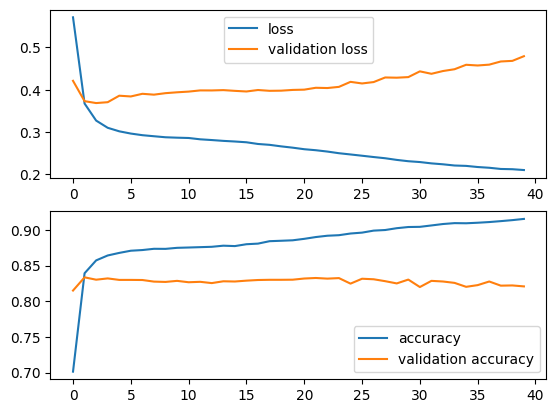

<Figure size 1000x600 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2)
plt.figure(figsize=(10,6))
axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='validation loss')
axs[0].legend()
axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='validation accuracy')
axs[1].legend()



In [ ]:
#visualize word embeddings

In [15]:
reverse_word_index = tokenizer.index_word

embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]
print(embedding_weights.shape)


(2000, 16)


In [16]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, voc_size):
  word_name = reverse_word_index[word_num]
  word_embedding= embedding_weights[word_num]
  out_m.write(word_name + "\n")
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")
out_v.close()
out_m.close()

# Import files utilities in Colab
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>